In [1]:
# ASE:
import ase as ASE
from ase import Atoms
from ase.visualize import view
from ase.io import read, write
from ase.neb import NEB, NEBOptimizer, NEBTools
from ase.optimize.bfgs import BFGS
from ase.visualize.plot import plot_atoms

from argparse import ArgumentParser
from neuralneb import painn, utils
from rmsd import kabsch_rmsd

# Standard
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


# Initial Inputs

-----------------------------------------

In [2]:
# Input the atoms for the stody
formula = 'H4CO' # This is the components making up methanol

# Number of initializations:
N = 120

# Variation of initialized atomic positions
variation = 2 * np.sqrt(6)

# --- MODEL ------------------------------------------
# Path to model:
statedict = torch.load("data/painn_transition1x.sd") 
model = painn.PaiNN(3, 256, 5);
model.load_state_dict(statedict);
model.eval();

print('Used variation: ' + str(variation))

Used variation: 4.898979485566356


-----------------------------------------

# Generating initial random configurations:

100 examples:


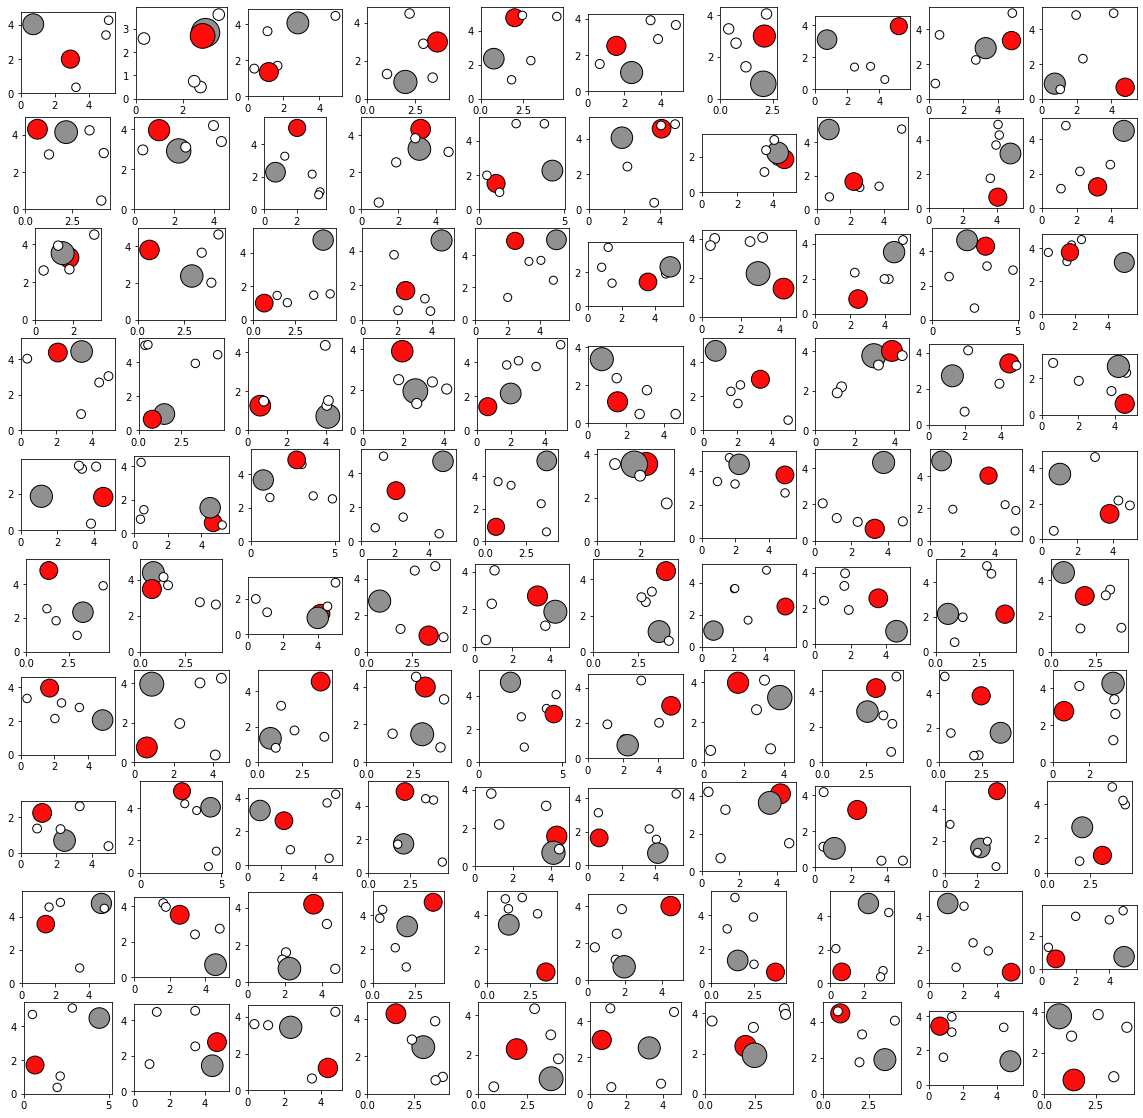

In [3]:
initConfig = Atoms(formula)
configs = [initConfig.copy() for _ in range(N)]

numAtoms = np.shape(initConfig.get_positions())[0]

for config in configs:
    randomPos = np.random.rand(numAtoms,3) * variation
    config.set_positions(randomPos)
    
    
print("100 examples:")
plt.figure(figsize=(20, 20))
I = 0
for i in range(10):
    for j in range(10):
        plt.subplot2grid((10,10), (i,j))
        plot_atoms(configs[I], radii=0.8)#rotation=('90x,45y,0z'))
        I = I + 1   

# Relaxing structures:

In [4]:
ditNotConverge = 0
convergedIndices = np.ones(len(configs)) == 1

i = 0

plotNotConverged = False

for config in configs:
    config.calc = utils.MLCalculator(model) # Assigning calculator
    
for config in configs:
    
    try:
        BFGS(config, logfile='trash.traj').run(fmax=0.05, steps=5000);
        config.center()
        i = i + 1
        
        
    except:
        ditNotConverge = ditNotConverge + 1
        
        convergedIndices[i] = False
        
        i = i + 1
            
        if(plotNotConverged == True):
            fig, ax = plt.subplots()
            plot_atoms(config, ax, radii=0.8)
            plt.show()
    
    # Printing progress:
    if(i%10 == 0):
        print(str(i) + '/' + str(len(configs)))

print('Done!')
print(str(ditNotConverge) + ' did not converge.')

10/120
20/120
30/120
40/120
50/120
60/120
70/120
80/120
90/120
100/120
110/120
120/120
Done!
0 did not converge.


## Deleting failed structures:

### Discarting non converged structures:

In [5]:
print(str(len(configs)) + ' configurations initialized.')

for i in range(len(configs)):
    if(False == convergedIndices[i]):
        del(configs[i])

print('Deleting non converged structures')
print(str(len(configs)) + ' configurations left.')

120 configurations initialized.
Deleting non converged structures
120 configurations left.


### Energi discard inputs:

-----------

In [6]:
Ehigh = 20
Elow = -30


-----------

### Discarting non physical structures based on there energy:

Computing energies of: 120 configurations.
True
119 configurations left, due to non valid energies.


Text(0.5, 0, 'Structure number')

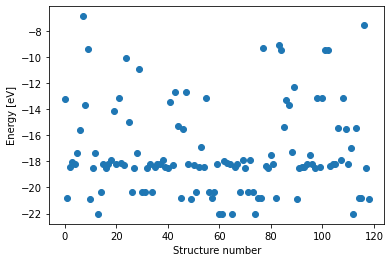

In [7]:
print('Computing energies of: ' + str(len(configs)) + ' configurations.')

valiedEnergyIndices = np.ones(len(configs))

for i in range(len(configs)):
    energy = configs[i].get_potential_energy()
    
    if(np.isnan(energy) or energy > Ehigh or energy < Elow):
        valiedEnergyIndices[i] = 0
        

for i in range(len(configs)):
    if(valiedEnergyIndices[i] == 0):
        print(valiedEnergyIndices[i] == 0)
    if(valiedEnergyIndices[i] == 0):
        del(configs[i])

# Computning filnal energies:
energies = np.zeros(len(configs))
for i in range(len(configs)):
    energies[i] = configs[i].get_potential_energy()
    
plt.scatter(np.arange(len(energies)),energies)


print(str(len(configs)) + ' configurations left, due to non valid energies.')
plt.ylabel('Energy [eV]')
plt.xlabel('Structure number')

### Plotting 100 remaning structures:

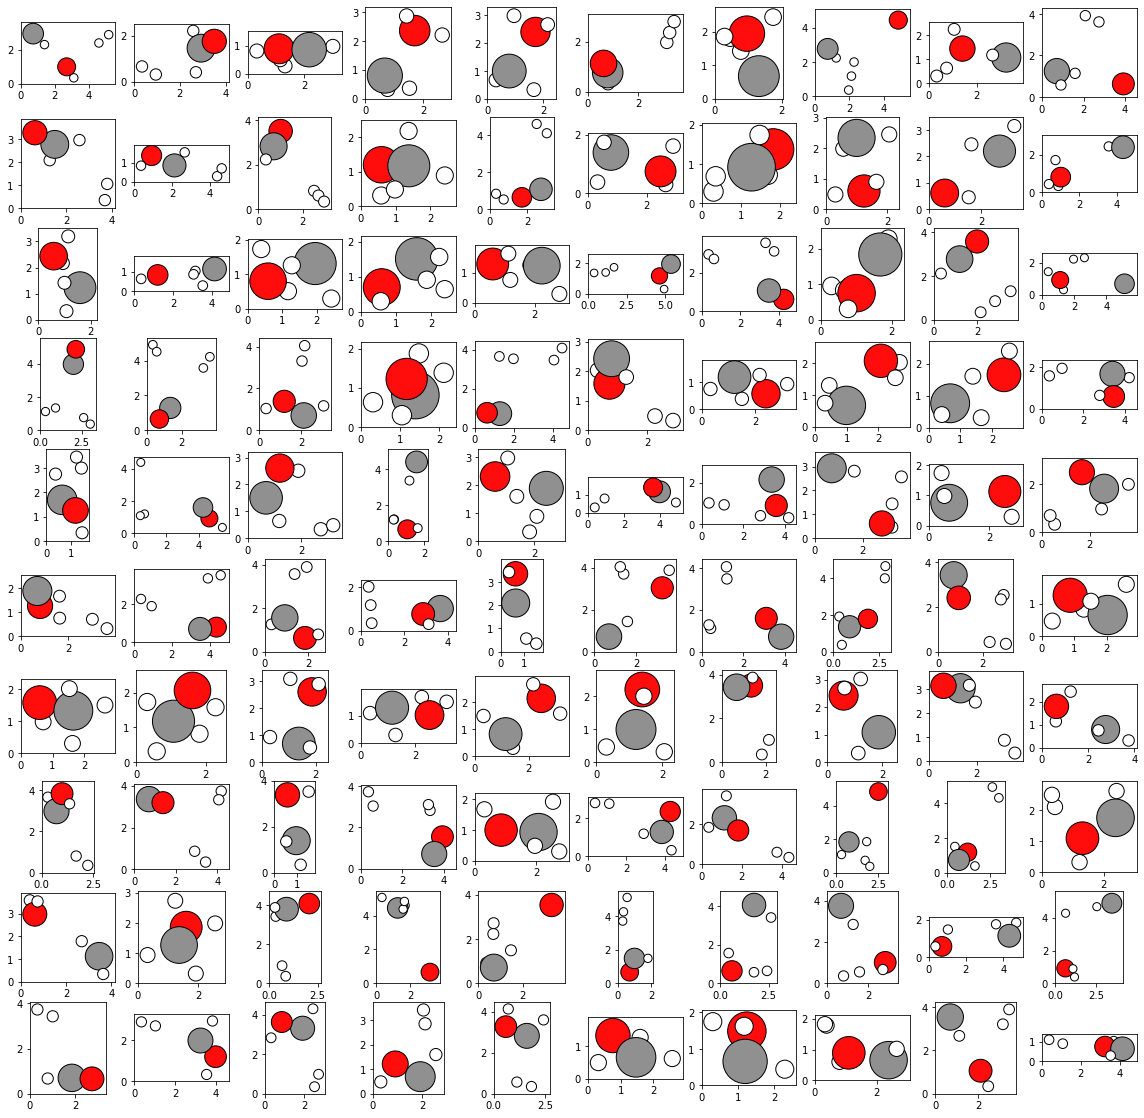

In [8]:
plt.figure(figsize=(20, 20))
I = 0
for i in range(10):
    for j in range(10):
        plt.subplot2grid((10,10), (i,j))
        
        try:
            plot_atoms(configs[I],radii=0.8)#rotation=('90x,45y,0z'))
            I = I + 1      
        
        except:
            break

# Saving obtained results:

In [10]:
saveConfigs = False

name = 'configsDec05-5-'
path = "configs_H4CO/"

if(saveConfigs == True):
    for i in range(len(configs)):
        write(path + name + str(i) + '.xyz', configs[i])
    print('Saved')
    
else:
    print('Not saved')

Not saved


# Importing configs:

In [11]:
loadConfigs = True

path = "configs_H4CO/"

if(loadConfigs == True):
    configs = []
    dirList = os.listdir(path)
    for i in range(0, len(dirList)):
        newConfig = read(path + dirList[i])
        newConfig.calc = utils.MLCalculator(model) # Assigning calculator
        configs.append(newConfig)
        
    
    print(str(len(configs)) + ' elements loaded.')
    
else:
    print('Nothing loaded')

1285 elements loaded.


# RMSD

### RMSD inputs:

-----------------------------

In [12]:
RMSDthreshold = 0.8

-----------------------------

In [13]:
inBasket = np.ones(len(configs)) # Undefined configs

configLabels = np.zeros(len(configs))

for i in range(len(configs)):
    
    if(inBasket[i] == 1):
        
        for j in range(len(configs)):
            
            RMSD = np.ones(len(configs)) + RMSDthreshold
            RMSD[j] = kabsch_rmsd(configs[i].positions, configs[j].positions, translate=True)

            for ii in range(len(RMSD)):
                if(RMSD[ii] < RMSDthreshold):
                    if(inBasket[ii] == 1):
                        configLabels[ii] = i
                        inBasket[ii] = 0
    
    if(i%10 == 0):
        print(str(i) + '/' + str(len(configs)))

print('Done!')            

0/1285
10/1285
20/1285
30/1285
40/1285
50/1285
60/1285
70/1285
80/1285
90/1285
100/1285
110/1285
120/1285
130/1285
140/1285
150/1285
160/1285
170/1285
180/1285
190/1285
200/1285
210/1285
220/1285
230/1285
240/1285
250/1285
260/1285
270/1285
280/1285
290/1285
300/1285
310/1285
320/1285
330/1285
340/1285
350/1285
360/1285
370/1285
380/1285
390/1285
400/1285
410/1285
420/1285
430/1285
440/1285
450/1285
460/1285
470/1285
480/1285
490/1285
500/1285
510/1285
520/1285
530/1285
540/1285
550/1285
560/1285
570/1285
580/1285
590/1285
600/1285
610/1285
620/1285
630/1285
640/1285
650/1285
660/1285
670/1285
680/1285
690/1285
700/1285
710/1285
720/1285
730/1285
740/1285
750/1285
760/1285
770/1285
780/1285
790/1285
800/1285
810/1285
820/1285
830/1285
840/1285
850/1285
860/1285
870/1285
880/1285
890/1285
900/1285
910/1285
920/1285
930/1285
940/1285
950/1285
960/1285
970/1285
980/1285
990/1285
1000/1285
1010/1285
1020/1285
1030/1285
1040/1285
1050/1285
1060/1285
1070/1285
1080/1285
1090/1285
1100/1285
1

In [14]:
for i in range(len(configLabels)):
    print('Config no.: ' + str(configLabels[i]) + ' accurances: ' + str(len(configLabels[configLabels == i])))

Config no.: 0.0 accurances: 44
Config no.: 0.0 accurances: 0
Config no.: 2.0 accurances: 11
Config no.: 3.0 accurances: 6
Config no.: 4.0 accurances: 9
Config no.: 5.0 accurances: 3
Config no.: 6.0 accurances: 1
Config no.: 7.0 accurances: 22
Config no.: 0.0 accurances: 0
Config no.: 9.0 accurances: 22
Config no.: 10.0 accurances: 17
Config no.: 11.0 accurances: 22
Config no.: 12.0 accurances: 9
Config no.: 13.0 accurances: 3
Config no.: 14.0 accurances: 21
Config no.: 15.0 accurances: 8
Config no.: 2.0 accurances: 0
Config no.: 11.0 accurances: 0
Config no.: 18.0 accurances: 16
Config no.: 19.0 accurances: 2
Config no.: 20.0 accurances: 10
Config no.: 21.0 accurances: 1
Config no.: 22.0 accurances: 4
Config no.: 23.0 accurances: 14
Config no.: 24.0 accurances: 25
Config no.: 0.0 accurances: 0
Config no.: 26.0 accurances: 3
Config no.: 27.0 accurances: 12
Config no.: 28.0 accurances: 26
Config no.: 29.0 accurances: 4
Config no.: 30.0 accurances: 5
Config no.: 31.0 accurances: 11
Config

(array([1.2e+03, 8.4e+01, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 1.0e+00]),
 array([5.28827411e-16, 2.21464124e+00, 4.42928248e+00, 6.64392371e+00,
        8.85856495e+00, 1.10732062e+01, 1.32878474e+01, 1.55024887e+01,
        1.77171299e+01, 1.99317711e+01, 2.21464124e+01]),
 <BarContainer object of 10 artists>)

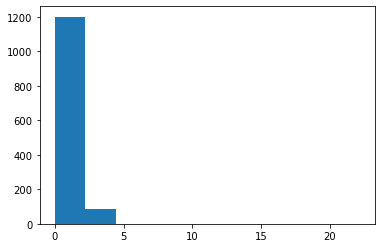

In [15]:
indexInvestagete = 0
view(configs[indexInvestagete])

RMSD = np.ones(len(configs)) + RMSDthreshold
for i in range(len(configs)):

    RMSD[i] = kabsch_rmsd(configs[indexInvestagete].positions, configs[i].positions, translate=True)
    
plt.hist(RMSD)

Text(0, 0.5, 'Density [Normalized units]')

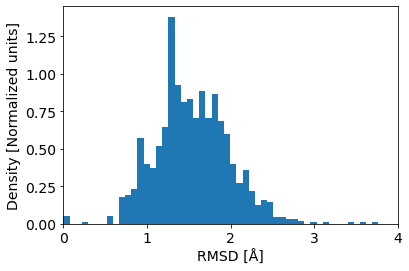

In [17]:

font = {
        'size'   : 14}
plt.rc('font', **font)



plt.hist(RMSD,300,density = True);


plt.xlim([0,4])
#plt.ylim([0,50])
plt.xlabel('RMSD [Å]')
plt.ylabel('Density [Normalized units]')

In [10]:
view(configs[51])

In [145]:
print(len(np.unique(configLabels)))
print(len(inBasket[inBasket == 1]))

print(np.where(configLabels == 28))
print(np.where(configLabels == 24))

668
0
(array([  28,  145,  199,  234,  379,  404,  408,  510,  511,  561,  608,
        627,  745, 1106, 1123], dtype=int64),)
(array([ 24,  50, 138, 456, 484, 492, 721, 766, 852, 863, 900, 965],
      dtype=int64),)


# NEB

Reactant and product for neb calculation

In [46]:
R = configs[24]
P = configs[10]

view(P)
view(R)

In [47]:
atom_inters = [R.copy() for _ in range(10)] + [P]

# assining the model as calculator:
for atom_inter in atom_inters:
    atom_inter.calc = utils.MLCalculator(model)
    
neb = NEB(atom_inters,climb=True)
neb.interpolate(method="idpp")
relax_neb = NEBOptimizer(neb)
relax_neb.run(fmax=0.3, steps=500)

nebtools = NEBTools(atom_inters)
fit = nebtools.get_fit()

energies = fit.fit_energies.tolist()
path = fit.fit_path.tolist()

                   Step     Time         fmax
NEBOptimizer[ode]:    0 17:16:29       7.5644
NEBOptimizer[ode]:    1 17:16:29       7.0526
NEBOptimizer[ode]:    2 17:16:29       7.2484
NEBOptimizer[ode]:    3 17:16:29       7.3235
NEBOptimizer[ode]:    4 17:16:29       9.7364
NEBOptimizer[ode]:    5 17:16:29      12.4418
NEBOptimizer[ode]:    6 17:16:29      11.8795
NEBOptimizer[ode]:    7 17:16:29       3.7202
NEBOptimizer[ode]:    8 17:16:30       3.5936
NEBOptimizer[ode]:    9 17:16:30       3.3074
NEBOptimizer[ode]:   10 17:16:30       2.9566
NEBOptimizer[ode]:   11 17:16:30       2.7522
NEBOptimizer[ode]:   12 17:16:30       2.7143
NEBOptimizer[ode]:   13 17:16:30       2.7435
NEBOptimizer[ode]:   14 17:16:30       2.6043
NEBOptimizer[ode]:   15 17:16:30       2.3492
NEBOptimizer[ode]:   16 17:16:30       2.3537
NEBOptimizer[ode]:   17 17:16:30       2.3936
NEBOptimizer[ode]:   18 17:16:30       2.5032
NEBOptimizer[ode]:   19 17:16:31       2.8743
NEBOptimizer[ode]:   20 17:16:31  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


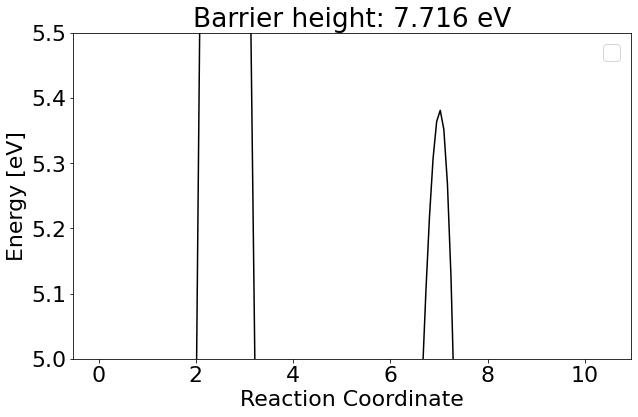

In [51]:
font = {
        'size'   : 22}
plt.rc('font', **font)

def mep_fig(path, energy):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(path, energy, color = 'black')
    #ax.grid()
    ax.set_title(f"Barrier height: {str(max(energy))[:5]} eV")
    ax.set_xlabel("Reaction Coordinate")
    ax.set_ylabel("Energy [eV]")
    ax.legend()
    ax.set_ylim([5,5.5])
    return fig


mep_fig(path, energies)
plt.show()


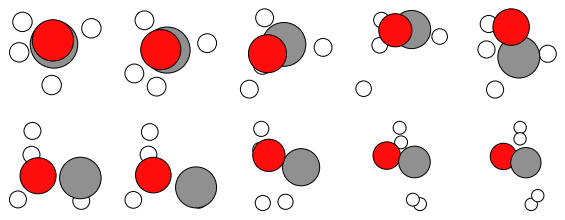

In [211]:

plt.figure(figsize=(10, 10))
I = 0
for i in range(2):
    for j in range(5):
        plt.subplot2grid((5,5), (i,j))
        plot_atoms(atom_inters[I],radii=0.8, rotation=('50x,-25y,-20z'))
        I = I + 1 
        plt.axis('off')
        
plt.show()

view(atom_inters[4])

#fig, ax = plt.subplots()
#plot_atoms(R, ax, radii=0.8)
#fig, ax = plt.subplots()
#plot_atoms(P, ax, radii=0.8)

In [213]:
view(atom_inters[4])

Text(0.5, 0, 'Reaction Coordinate [Å]')

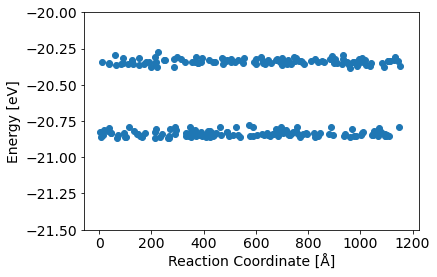

In [53]:
font = {
        'size'   : 14}
plt.rc('font', **font)

energies = np.zeros(len(configs))
for i in range(len(configs)):
    energies[i] = configs[i].get_potential_energy()

plt.scatter(np.arange(len(energies)),energies)
plt.ylim(-21.5,-20)

plt.ylabel('Energy [eV]')
plt.xlabel("Reaction Coordinate [Å]")

In [55]:
5.4-22+20.3

3.6999999999999993

In [18]:
upper = np.where(energies < -20)
lower = np.where(energies > -20.5)


np.intersect1d(lower, upper)

array([  10,   36,   39,   59,   65,   84,   90,   93,  112,  124,  126,
        129,  152,  153,  170,  178,  189,  198,  213,  214,  218,  221,
        225,  250,  252,  286,  288,  298,  314,  329,  355,  365,  372,
        377,  378,  388,  392,  419,  436,  444,  472,  473,  474,  485,
        491,  504,  506,  520,  530,  552,  553,  591,  599,  601,  619,
        628,  629,  636,  645,  658,  676,  680,  690,  695,  700,  701,
        717,  720,  723,  736,  746,  749,  755,  764,  772,  776,  783,
        810,  828,  838,  854,  860,  884,  893,  899,  902,  911,  931,
        932,  933,  947,  952,  957,  960,  972,  977,  988,  989,  995,
       1006, 1009, 1017, 1023, 1035, 1042, 1082, 1091, 1104, 1105, 1110,
       1114, 1130, 1131, 1143, 1150], dtype=int64)

In [199]:


view(configs[39])